In [2]:
import pandas as pd

from analysis.jp.flat import prepared_data

def calculate_monthly_averages(df: pd.DataFrame = prepared_data):
    '''
    Calculates and prints out average kWh usage for January, December, April, and May.

    Parameters:
        df (pd.DataFrame): The dataframe containing 'hour', 'month', and 'kwh' columns.
    '''

    # Calculating average kWh for specific months
    for month in [1, 12, 4, 5]:  # January, December, April, May
        avg_kwh = df[df['month'] == month]['kwh'].mean()
        month_name = pd.to_datetime(f"{month}", format="%m").month_name()
        print(f"Average kWh in {month_name}: {avg_kwh:.2f}")

if __name__ == "__main__":
    calculate_monthly_averages()


Average kWh in January: 0.99
Average kWh in December: 1.01
Average kWh in April: 0.78
Average kWh in May: 0.73


In [3]:
import pandas as pd

from analysis.jp.flat import prepared_data

def calculate_period_average_costs(df: pd.DataFrame = prepared_data):
    '''
    Calculates and prints out the average costs for mid-peak, off-peak, and on-peak periods.

    Parameters:
        df (pd.DataFrame): The dataframe containing 'period', 'date', and 'total_cost' columns.
    '''

    # Grouping by period and calculating the average cost
    avg_costs = df.groupby('period')['total_cost'].mean()

    for period in avg_costs.index:
        print(f"Average cost for {period} period: ${avg_costs[period]:.2f}")

if __name__ == "__main__":
    calculate_period_average_costs()


Average cost for Mid-peak: 7AM to 5PM, 9PM to 11PM period: $0.16
Average cost for Off-peak: 12AM to 7AM period: $0.10
Average cost for On-peak: 5PM to 9PM period: $0.15


In [4]:
import pandas as pd
from utils.runtime import connect_to_db

def calculate_energy_usage_stats():
    '''
    Calculates and prints out the statistics for total energy usage.

    Statistics include:
        - Lowest and highest monthly kWh usage.
        - Average monthly energy usage before and after September 2022.
    '''

    # Connecting to the database and querying the data
    query = """
        SELECT date, kwh
        FROM fct_electric_brew fe
        LEFT JOIN dim_datetimes dd ON fe.dim_datetimes_id = dd.id
        WHERE dd.date <= '2023-07-31'
    """
    electric_brew = connect_to_db()
    df = electric_brew.query(query).to_df()

    # Preparing the dataframe
    df['month'] = df['date'].dt.to_period('M')
    monthly_usage = df.groupby('month')['kwh'].sum()

    # Lowest and highest monthly kWh usage
    lowest_usage = monthly_usage.min()
    highest_usage = monthly_usage.max()
    print(f"Lowest monthly usage: {lowest_usage} kWh")
    print(f"Highest monthly usage: {highest_usage} kWh")

    # Average usage before and after September 2022
    solar_start = pd.Period('2022-09')
    avg_usage_pre_solar = monthly_usage[monthly_usage.index < solar_start].mean()
    avg_usage_post_solar = monthly_usage[monthly_usage.index >= solar_start].mean()
    print(f"Average monthly usage before solar power: {avg_usage_pre_solar:.2f} kWh")
    print(f"Average monthly usage after solar power: {avg_usage_post_solar:.2f} kWh")

if __name__ == "__main__":
    calculate_energy_usage_stats()


Lowest monthly usage: 6966.835 kWh
Highest monthly usage: 15031.381 kWh
Average monthly usage before solar power: 11003.24 kWh
Average monthly usage after solar power: 12216.07 kWh


In [6]:
import pandas as pd
from utils.runtime import connect_to_db

def calculate_cost_statistics():
    '''
    Calculates and prints out the mean monthly total energy cost, and mean monthly costs by generation type (solar and conventional).

    '''

    # Connecting to the database and querying the data
    query = """
        SELECT supplier, date, kwh, total_cost
        FROM fct_electric_brew fe
        LEFT JOIN dim_datetimes dd ON fe.dim_datetimes_id = dd.id
        LEFT JOIN dim_bills db ON fe.dim_bills_id = db.id
        WHERE dd.date <= '2023-07-31';
    """
    electric_brew = connect_to_db()
    df = electric_brew.query(query).to_df()

    # Preparing the dataframe
    df['month'] = df['date'].dt.to_period('M')
    df.sort_values('date', inplace=True)
    df = df.loc[df.total_cost != 0]
    df['energy_type'] = df['supplier'].apply(lambda x: 'Solar' if x == 'Ampion' else 'conventional_supplier')

    # Mean monthly total energy cost
    mean_monthly_cost = df.groupby('month')['total_cost'].sum().mean()
    print(f"Mean monthly total energy cost: ${mean_monthly_cost:.2f}")

    # Monthly costs by generation type
    monthly_costs_by_type = df.groupby(['energy_type', 'month'])['total_cost'].sum()
    mean_monthly_costs_by_type = monthly_costs_by_type.groupby('energy_type').mean()
    for energy_type in mean_monthly_costs_by_type.index:
        print(f"Mean monthly cost for {energy_type}: ${mean_monthly_costs_by_type[energy_type]:.2f}")

if __name__ == "__main__":
    calculate_cost_statistics()


Mean monthly total energy cost: $1773.40
Mean monthly cost for Solar: $1461.84
Mean monthly cost for conventional_supplier: $1074.25


In [11]:
import pandas as pd
from utils.runtime import connect_to_db

def calculate_solar_projections_statistics():
    '''
    Calculates and prints out detailed statistics for actual vs. projected energy costs in a hypothetical full solar scenario,
    and identifies months with significant cost differences.

    Statistics include:
        - Average actual cost per month.
        - Average projected cost per month under full solar.
        - Average cost per kWh for solar energy.
        - Standard deviation of the cost per kWh for solar energy.
        - Months with notably high percentage differences.
    '''

    # Connecting to the database and querying the data
    query = """
        SELECT supplier, date, kwh, total_cost
        FROM fct_electric_brew fe
        LEFT JOIN dim_datetimes dd ON fe.dim_datetimes_id = dd.id
        LEFT JOIN dim_bills db ON fe.dim_bills_id = db.id
        WHERE dd.date >= '2022-09-01' AND dd.date <= '2023-07-31';
    """
    electric_brew = connect_to_db()
    df = electric_brew.query(query).to_df()

    # Engineering the dataframe
    df['month'] = df['date'].dt.to_period('M') 
    df.sort_values('date', inplace=True)
    df = df.loc[df.total_cost != 0]
    df['energy_type'] = df['supplier'].apply(lambda x: 'Solar' if x == 'Ampion' else 'conventional_supplier')
    df_grouped = df.groupby(['month', 'energy_type'], sort=False).agg({'total_cost': 'sum', 'kwh': 'sum'}).unstack(fill_value=0)
    df_grouped['solar_cost_per_kwh'] = df_grouped['total_cost']['Solar'] / df_grouped['kwh']['Solar']
    df_grouped['total_kwh'] = df_grouped['kwh']['Solar'] + df_grouped['kwh']['conventional_supplier']
    df_grouped['total_cost_2'] = df_grouped['total_cost']['Solar'] + df_grouped['total_cost']['conventional_supplier']
    df_grouped['projected_costs'] = df_grouped['solar_cost_per_kwh'] * df_grouped['total_kwh']

    # Calculating statistics
    avg_actual_cost_per_month = df_grouped['total_cost_2'].mean()
    avg_projected_cost_per_month = df_grouped['projected_costs'].mean()
    avg_cost_per_kwh_solar = df_grouped['solar_cost_per_kwh'].mean()
    std_dev_cost_per_kwh_solar = df_grouped['solar_cost_per_kwh'].std()

    # Calculate percentage differences for all months
    percent_diff = (((df_grouped['projected_costs'] - df_grouped['total_cost_2']) / df_grouped['total_cost_2']) * 100)

    # Identify significant months
    significant_months = percent_diff[percent_diff.abs() > 10]  # Threshold for significance set at 10%

    print(f"Average actual cost per month: ${avg_actual_cost_per_month:.2f}")
    print(f"Average projected cost per month under full solar: ${avg_projected_cost_per_month:.2f}")
    print(f"Average cost per kWh for solar energy: ${avg_cost_per_kwh_solar:.3f}")
    print(f"Standard deviation of the cost per kWh for solar energy: ${std_dev_cost_per_kwh_solar:.3f}")
    print("Significant months (with percentage difference > 10%):")
    for month, diff in significant_months.items():
        print(f"  - {month}: {diff:.2f}%")

    electric_brew.close()

if __name__ == "__main__":
    calculate_solar_projections_statistics()


Average actual cost per month: $2362.32
Average projected cost per month under full solar: $2524.36
Average cost per kWh for solar energy: $0.224
Standard deviation of the cost per kWh for solar energy: $0.025
Significant months (with percentage difference > 10%):
  - 2022-12: 50.31%
  - 2023-01: 36.41%


In [12]:
import pandas as pd
from sklearn.ensemble import IsolationForest

from analysis.jp.flat import prepared_data

def calculate_anomaly_statistics(df: pd.DataFrame = prepared_data):
    '''
    Calculates and prints out statistics related to anomaly detection on 'total_cost'.

    Parameters:
        df (pd.DataFrame): The dataframe containing the 'total_cost' column.
    '''

    # Statistics before anomaly detection
    initial_count = len(df)
    min_cost_before = df['total_cost'].min()
    max_cost_before = df['total_cost'].max()
    mean_cost_before = df['total_cost'].mean()
    std_dev_cost_before = df['total_cost'].std()

    print(f"Before Anomaly Detection - Count: {initial_count}, Min: ${min_cost_before:.2f}, Max: ${max_cost_before:.2f}, Mean: ${mean_cost_before:.4f}, Std Dev: ${std_dev_cost_before:.4f}")

    # Anomaly detection with Isolation Forest
    isolation_forest = IsolationForest(contamination=0.001, n_jobs=-1, random_state=0)
    outliers = isolation_forest.fit_predict(df[['total_cost']])
    df_filtered = df[outliers == 1]

    # Statistics after anomaly detection
    mean_cost_after = df_filtered['total_cost'].mean()
    std_dev_cost_after = df_filtered['total_cost'].std()
    max_cost_after = df_filtered['total_cost'].max()
    anomalies_count = initial_count - len(df_filtered)

    print(f"After Anomaly Detection - Mean: ${mean_cost_after:.4f}, Std Dev: ${std_dev_cost_after:.4f}, Max: ${max_cost_after:.2f}, Anomalies Removed: {anomalies_count}")

if __name__ == "__main__":
    calculate_anomaly_statistics()


Before Anomaly Detection - Count: 301281, Min: $0.00, Max: $3.63, Mean: $0.1389, Std Dev: $0.2340
After Anomaly Detection - Mean: $0.1371, Std Dev: $0.2239, Max: $2.33, Anomalies Removed: 220


In [13]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import re

from analysis.jp.jp04 import without_anomalies

def lasso_feature_importance(df: pd.DataFrame = without_anomalies):
    '''
    Analyzes and prints out the most important features for predicting 'total_cost' using LASSO.

    Parameters:
        df (pd.DataFrame): The dataframe returned from the `remove_anomalies` function.
    '''

    # Preprocessing the data
    df = df.drop(columns=[col for col in df.columns if 'id' in col or col in ['billing_interval', 'invoice_number', 
                   'street', 'label', 'source', 'account_number', 'account_number_dm', 'account_number_db',
                   'kwh', 'period', 'week', 'month', 'quarter', 
                   'delivery_cost', 'supply_cost', 'tax_cost', 'service_cost',
                   'taxes', 'service_charge']], axis=1).dropna()

    X = df.drop('total_cost', axis=1)
    y = df['total_cost']

    # Define features to engineer
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.union(['hour'])
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

    # Creating a pipeline with preprocessing and LASSO
    model = Pipeline(steps=[('preprocessor', ColumnTransformer([('num', StandardScaler(), numeric_features),
                                                               ('cat', OneHotEncoder(), categorical_features)])),
                            ('feature_selector', SelectFromModel(LassoCV(max_iter=50000, n_jobs=-1, random_state=0)))])

    # Splitting the data and fitting the model
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    model.fit(X_train, y_train)

    # Accessing the fitted LassoCV model, getting its feature names, and applying the SelectFromModel mask
    lasso_cv = model.named_steps['feature_selector'].estimator_
    feature_names = model.named_steps['preprocessor'].get_feature_names_out()
    selection_mask = model.named_steps['feature_selector'].get_support()
    shortened_names = [re.split('[: ]', name)[0] for name in feature_names[selection_mask]]

    # Creating a pandas.Series for easy interpretation
    ft_importance = pd.Series(data=lasso_cv.coef_[selection_mask], index=shortened_names).sort_values(ascending=False)

    return ft_importance

if __name__ == "__main__":
    ft_importance = lasso_feature_importance()
    print(ft_importance)


2023-12-23 14:41:44,118 | INFO | Loading pickled data from jp04.pkl.


cat__operational_area_Package/Hot/Chill    0.710807
cat__operational_area_Industrial-3         0.409002
cat__hour_14                               0.087205
cat__hour_15                               0.085489
cat__operational_area_Industrial-2         0.084308
cat__hour_13                               0.077031
cat__hour_16                               0.076288
num__supply_rate                           0.066941
cat__hour_12                               0.065555
cat__hour_17                               0.065034
cat__hour_11                               0.045324
cat__hour_18                               0.043940
num__kwh_delivered                         0.034085
cat__hour_19                               0.028169
cat__hour_10                               0.023867
cat__supplier_CONSTELLATION                0.023068
cat__month_name_December                   0.020814
cat__month_name_November                   0.020700
cat__supplier_MEGA                         0.020226
cat__month_n

In [14]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from analysis.jp.jp06 import lasso_outputs

def linear_regression_evaluation(X_train: np.ndarray = lasso_outputs['X_train'], 
                                 X_test: np.ndarray = lasso_outputs['X_test'], 
                                 y_train: pd.Series = lasso_outputs['y_train'], 
                                 y_test: pd.Series = lasso_outputs['y_test']):
    '''
    Fits a Linear Regression model and calculates R², MSE, and residual analysis.

    Parameters:
        X_train (np.ndarray): The transformed training feature set from LASSO feature selection.
        X_test  (np.ndarray): The transformed test feature set from LASSO feature selection.
        y_train (pd.Series): The training target variable.
        y_test  (pd.Series): The test target variable.
    '''

    # Fitting the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculating R² and MSE
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Residual analysis
    residuals = y_test - y_pred
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)
    min_residual = np.min(residuals)
    max_residual = np.max(residuals)

    print(f"R² (Coefficient of Determination): {r2:.3f}")
    print(f"MSE (Mean Squared Error): {mse:.3f}")
    print(f"Mean Residual: {mean_residual:.3f}")
    print(f"Standard Deviation of Residuals: {std_residual:.3f}")
    print(f"Minimum Residual: {min_residual:.3f}")
    print(f"Maximum Residual: {max_residual:.3f}")

if __name__ == "__main__":
    linear_regression_evaluation()


2023-12-23 14:55:16,630 | INFO | Loading pickled data from jp06.pkl.


R² (Coefficient of Determination): 0.674
MSE (Mean Squared Error): 0.024
Mean Residual: -0.000
Standard Deviation of Residuals: 0.153
Minimum Residual: -0.775
Maximum Residual: 1.666


In [15]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from analysis.jp.jp06 import lasso_outputs

def evaluate_random_forest(X: np.ndarray = lasso_outputs['X_train'], 
                           y: pd.Series = lasso_outputs['y_train']) -> None:
    '''
    Fits a Random Forest Regressor model and evaluates its performance.

    Parameters:
        X (np.ndarray): The transformed training feature set from LASSO feature selection.
        y (pd.Series): The training target variable.
    '''

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    # Initialize the Random Forest Regressor
    rf = RandomForestRegressor(random_state=0)

    # Hyperparameter Grid
    hyperparameter_grid = {'n_estimators': [2, 4, 8, 16, 32, 64],
                           'max_depth': [2, 4, 8, 16],
                           'min_samples_split': [2, 4, 8, 16],
                           'min_samples_leaf': [2, 4, 8, 16]}

    # Randomized Search with Cross-Validation
    random_search = RandomizedSearchCV(rf, hyperparameter_grid, n_jobs=-1, random_state=0)
    random_search.fit(X_train, y_train)

    # Best model and predictions
    best_rf = random_search.best_estimator_
    y_pred_rf = best_rf.predict(X_test)

    # Calculating R² and MSE
    r2_rf = r2_score(y_test, y_pred_rf)
    mse_rf = mean_squared_error(y_test, y_pred_rf)

    # Outputting the results
    print(f"Random Forest R² (Coefficient of Determination): {r2_rf:.3f}")
    print(f"Random Forest MSE (Mean Squared Error): {mse_rf:.3f}")
    print("Random Forest Best Hyperparameters:")
    print(random_search.best_params_)

if __name__ == "__main__":
    evaluate_random_forest()


Random Forest R² (Coefficient of Determination): 0.781
Random Forest MSE (Mean Squared Error): 0.015
Random Forest Best Hyperparameters:
{'n_estimators': 32, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 16}


In [16]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

from analysis.jp.jp06 import lasso_outputs
from analysis.jp.jp08 import random_forest_outputs

def evaluate_cross_validation(X: np.ndarray = lasso_outputs['X_train'], 
                              y: pd.Series = lasso_outputs['y_train'], 
                              best: RandomForestRegressor = random_forest_outputs['best']) -> None:
    '''
    Performs cross-validation on Random Forest and Linear Regression models and prints out R² scores for each fold.

    Parameters:
        X (np.ndarray): The transformed training feature set from LASSO feature selection.
        y (pd.Series): The training target variable.
        best (RandomForestRegressor): The best-fitted Random Forest model.
    '''

    # Cross-validation on Random Forest
    cv_scores_rf = cross_val_score(best, X, y, cv=8, scoring='r2', n_jobs=-1)

    # Cross-validation on Linear Regression
    linear_regression = LinearRegression()
    cv_scores_lr = cross_val_score(linear_regression, X, y, cv=8, scoring='r2', n_jobs=-1)

    # Printing R² scores for each fold
    for i in range(len(cv_scores_rf)):
        print(f"Fold {i+1}: Random Forest R²: {cv_scores_rf[i]:.3f}, Linear Regression R²: {cv_scores_lr[i]:.3f}")

    # Printing standard deviations of the R² scores
    std_dev_rf = np.std(cv_scores_rf)
    std_dev_lr = np.std(cv_scores_lr)
    print(f"Standard Deviation of R² Scores - Random Forest: {std_dev_rf:.3f}, Linear Regression: {std_dev_lr:.3f}")

if __name__ == "__main__":
    evaluate_cross_validation()


2023-12-23 15:08:37,522 | INFO | Loading pickled data from jp08.pkl.


Fold 1: Random Forest R²: 0.786, Linear Regression R²: 0.676
Fold 2: Random Forest R²: 0.794, Linear Regression R²: 0.676
Fold 3: Random Forest R²: 0.781, Linear Regression R²: 0.657
Fold 4: Random Forest R²: 0.786, Linear Regression R²: 0.661
Fold 5: Random Forest R²: 0.799, Linear Regression R²: 0.676
Fold 6: Random Forest R²: 0.784, Linear Regression R²: 0.684
Fold 7: Random Forest R²: 0.776, Linear Regression R²: 0.662
Fold 8: Random Forest R²: 0.788, Linear Regression R²: 0.678
Standard Deviation of R² Scores - Random Forest: 0.007, Linear Regression: 0.009


2023-12-23 15:23:38,338 | INFO | Loading pickled data from jp10.pkl.
/var/folders/_g/f31lw6dn4q9bs0tpq1pl_lrw0000gn/T/ipykernel_2353/1097131422.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pct_changes, y=pct_changes.index, palette='twilight')


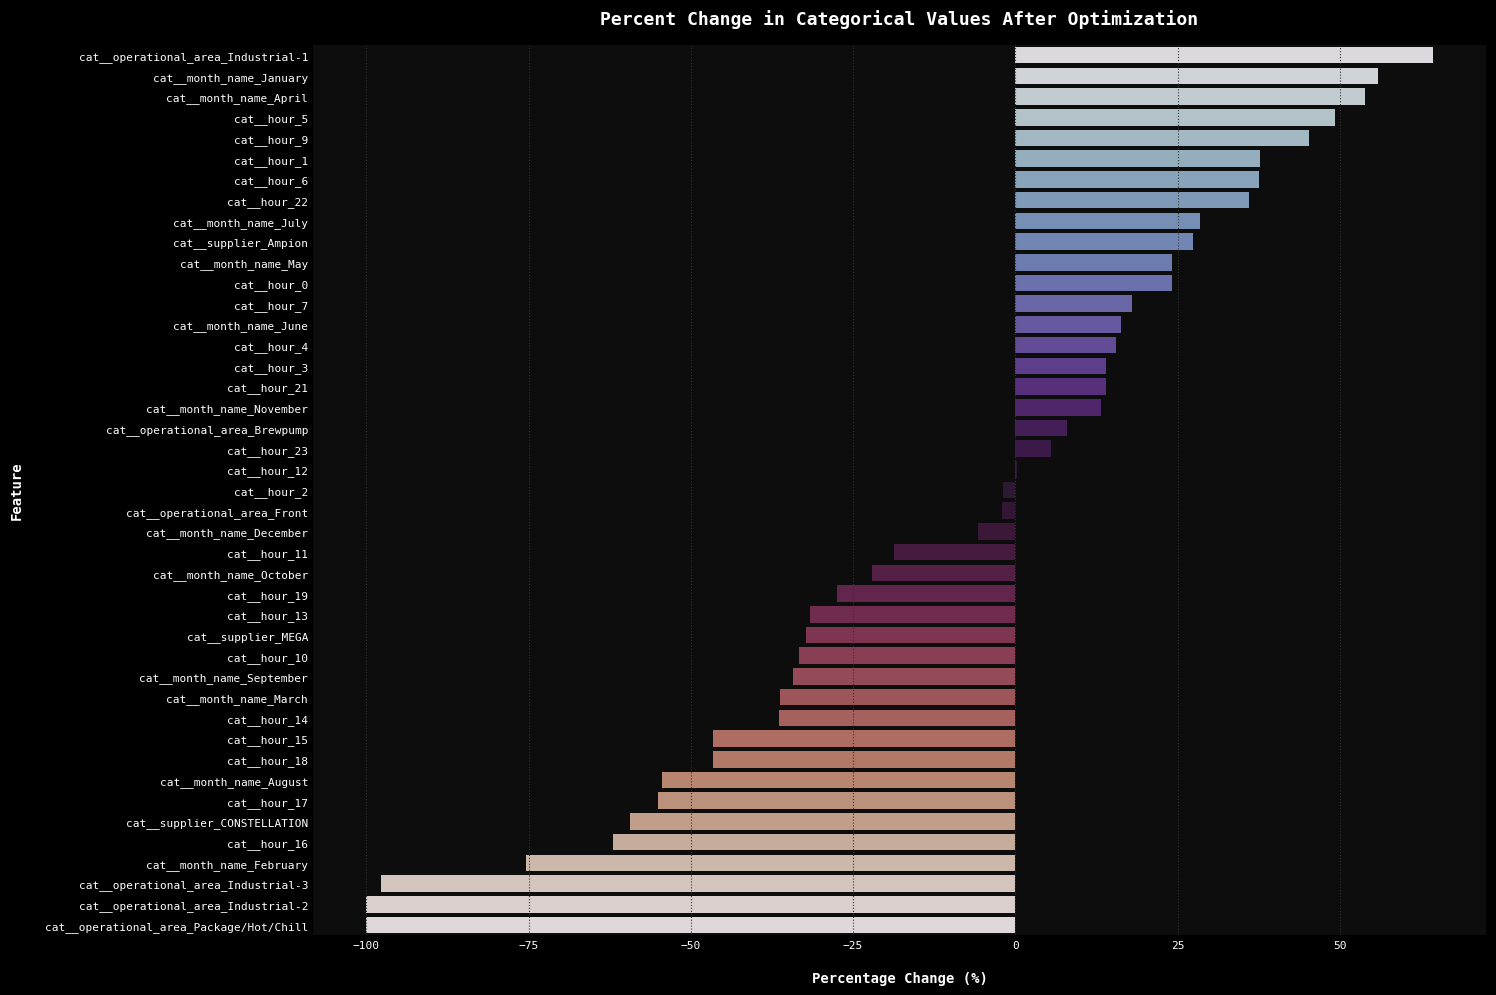

cat__operational_area_Industrial-1          64.319562
cat__month_name_January                     55.881628
cat__month_name_April                       53.912065
cat__hour_5                                 49.328838
cat__hour_9                                 45.246756
cat__hour_1                                 37.692436
cat__hour_6                                 37.518596
cat__hour_22                                35.979195
cat__month_name_July                        28.400256
cat__supplier_Ampion                        27.321911
cat__month_name_May                         24.142854
cat__hour_0                                 24.140876
cat__hour_7                                 18.006564
cat__month_name_June                        16.367284
cat__hour_4                                 15.483472
cat__hour_3                                 14.038813
cat__hour_21                                13.911273
cat__month_name_November                    13.277652
cat__operational_area_Brewpu

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from analysis.jp.jp06 import lasso_outputs
from analysis.jp.jp10 import slsqp_outputs

def calculate_percent_changes(X: np.ndarray = lasso_outputs['X_train'], 
                              optimized_sets: list = slsqp_outputs['optimized_sets'], 
                              feature_names: list = lasso_outputs['ft_names']) -> None:
    '''
    Calculates and visualizes the percentage changes in categorical values after optimization.

    Parameters:
        X (np.ndarray): The transformed training feature set from LASSO feature selection.
        optimized_sets (list): The optimized feature sets that meet the desired cost bounds after optimization.
        feature_names (list): A list of feature names after feature selection and transformation by the LASSO model.
    '''

    # Convert the list of feature arrays into a DataFrame and calculate the means
    optimized_means = pd.DataFrame(optimized_sets, columns=feature_names).mean()
    original_means = pd.DataFrame(X.toarray(), columns=feature_names).mean()

    # Compute and round the percentage changes
    pct_changes = ((optimized_means - original_means) / original_means * 100).sort_values(ascending=False)
    pct_changes = pct_changes[~pct_changes.index.str.startswith('num_')]

    # Plotting the percentage changes
    sns.barplot(x=pct_changes, y=pct_changes.index, palette='twilight')
    plt.xlabel('Percentage Change (%)')
    plt.ylabel('Feature')
    plt.title('Percent Change in Categorical Values After Optimization')
    plt.show()

    return pct_changes

if __name__ == "__main__":
    percent_changes = calculate_percent_changes()
    print(percent_changes)
